### Spark Structured Streaming Word Count Example <a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html" target="_blank">[REF]</a>
Structured Streaming is a scalable and fault-tolerant stream processing engine built on the Spark SQL engine. You can express your streaming computation the same way you would express a batch computation on static data
This is a simple example of a Structured Streaming query adapted from Spark's official documentation.

Let’s say you want to maintain a running word count of text data received from a data server listening on a TCP socket.

First, we have to import the necessary classes and create a local SparkSession, the starting point of all functionalities related to Spark.

In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

spark = SparkSession \
    .builder \
    .appName("StructuredNetworkWordCount") \
    .getOrCreate()


Next, let’s create a streaming DataFrame that represents text data received from a server listening on localhost:9999, and transform the DataFrame to calculate word counts.

In [ ]:
# Create DataFrame representing the stream of input lines from connection to localhost:9999
lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

# Split the lines into words
words = lines.select(
   explode(
       split(lines.value, " ")
   ).alias("word")
)

# Generate running word count
wordCounts = words.groupBy("word").count()

This lines DataFrame represents an unbounded table containing the streaming text data. This table contains one column of strings named “value”, and each line in the streaming text data becomes a row in the table. Note, that this is not currently receiving any data as we are just setting up the transformation, and have not yet started it. Next, we have used two built-in SQL functions - split and explode, to split each line into multiple rows with a word each. In addition, we use the function alias to name the new column as “word”. Finally, we have defined the wordCounts DataFrame by grouping by the unique values in the Dataset and counting them. Note that this is a streaming DataFrame which represents the running word counts of the stream.

In [ ]:
# Start running the query that prints the running counts to the console
query = wordCounts \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

After this code is executed, the streaming computation will have started in the background. Now we want to send data to the socket so that it is picked up and processed by our streaming code.
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Writing to the socket :</strong>In this example, we are reading the data that is coming into the port 9999. To send data to the socket do the following:
<ul>
    <li>Open new terminal in Ubuntu</li>
    <li>Type the command <code>nc -l localhost 9999</code> (as shown in first figure below)</li>
    <li>Enter different words and sentences</li>
    <li>Check the <strong>jupyter terminal</strong> to see the word count (as shown in the second figure below)</li>
</ul>
</div>

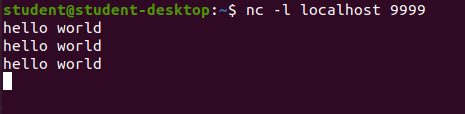

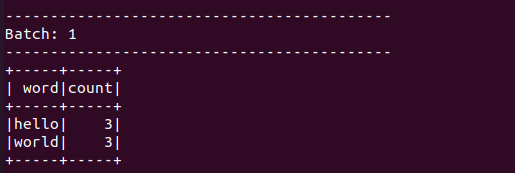

Instead of showing it in the terminal, it is more intuitive to display it to the user. We can use <code>format=memory</code> to save the output as a temporary table in the memory, which can later be accessed using SQL query.

In [ ]:
#First stop the previously running streaming query
query.stop()

In [ ]:
query = wordCounts \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("wc")\
    .start()


In [ ]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [ ]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    df = spark.sql("select * from wc").toPandas()
    
    if(len(df)>0):        
        x = df['word'].to_list()
        y = df['count'].to_list() 
        ax.clear()
        ax.bar(x, y)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        fig.canvas.draw()
        
    time.sleep(1)
    


Run the above query, this will continously check the socket for new words and display the count in the graph. The socket input sample and the output for the same is shown below.
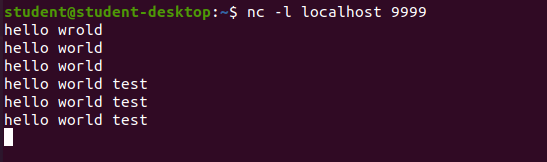

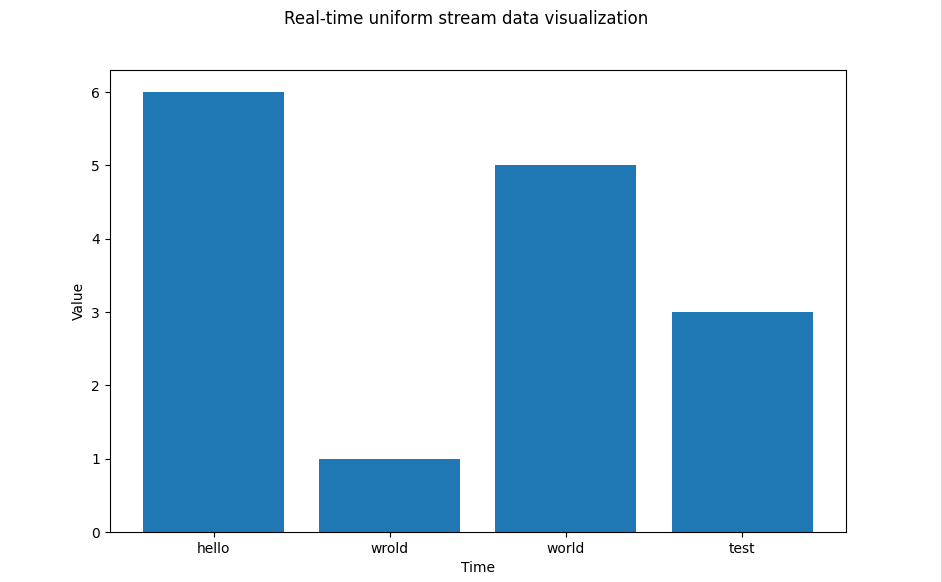